In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import json
%cd /content/drive/My\ Drive/Colab\ Notebooks


/content/drive/My Drive/Colab Notebooks


In [ ]:
!ls


'Copy of LRCN2.ipynb'   mesonet_original.ipynb	  Untitled1.ipynb
 LRCN2.ipynb	        model_regularization.h5
 LRCN_dataset1	        Untitled0.ipynb


In [ ]:
        basedir = "./LRCN_dataset1"
        print(os.path.isdir(basedir))
        all_metadata_filenames = []
        all_video_filenames = []
        for dirpath, _, filenames in os.walk(basedir):
            for filename in filenames:
                if filename.endswith(".json"):
                    all_metadata_filenames.append(os.path.join(dirpath, filename).replace("\\","/"))
                elif filename.endswith(".jpg"):
                    all_video_filenames.append(os.path.join(dirpath, filename).replace("\\","/"))      

True


In [ ]:
        metadata = {}
        for cur_metadata_filename in all_metadata_filenames:
            with open(cur_metadata_filename) as f_in:
                cur_metadata = json.load(f_in)
                for cur_key in cur_metadata:
                    # Store expanded versions of paths of videos in metadata
                    full_filename = os.path.join(os.path.dirname(cur_metadata_filename), cur_key.replace('.mp4','.jpg')).replace("\\","/")
                    metadata[full_filename] = {'label': cur_metadata[cur_key]['label']}
                    if 'original' in cur_metadata[cur_key] and cur_metadata[cur_key]['original']:
                        full_orig_filename = os.path.join(os.path.dirname(cur_metadata_filename), cur_metadata[cur_key]['original'].replace('.mp4','.jpg')).replace("\\","/")
                        metadata[full_filename]['original'] = full_orig_filename

In [ ]:
        real_videos = []
        fake_videos = []
        for cur_video_filename in all_video_filenames:
            if metadata[cur_video_filename]['label'] == "FAKE":
                fake_videos.append(cur_video_filename)
            elif metadata[cur_video_filename]['label'] == "REAL":
                real_videos.append(cur_video_filename)
        # Sort the pathnames since consecutive runs of os.walk aren't guaranteed
        # to return all the data in the same order
        real_videos.sort()
        fake_videos.sort()

In [ ]:
import cv2
import glob
import random
paths,Y=[],[]
fake=random.sample(fake_videos,2400)
#real_videos=real_videos[:1200]
#fake=fake[:2400]
for x in real_videos:
    paths.append(x)
    Y.append(0)
for x in fake:
    paths.append(x)
    Y.append(1)

In [ ]:
print(len(real_videos))

1936


In [ ]:
def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

In [ ]:
paths,y=shuffle(paths,Y)

In [ ]:
def get_birghtness(img):
    return img/img.max()

In [ ]:
from PIL import Image 
def process_img(img):
    imgs=[]
    
    for x in range(10):
        imgs.append(get_birghtness(img[:,x*240:(x+1)*240,:]))
    return np.array(imgs)

In [ ]:

def gets(paths):
    al=[]
    for x in paths:
        img=cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(2400,240))
        al.append(process_img(img))
    return al
def generator(paths,y,batch_size=16):
    while True:
        for x in range(len(paths)//batch_size):
            if x*batch_size+batch_size>len(paths):
                yield np.array(gets(paths[x*batch_size:])),np.array(y[x*batch_size:])
            yield np.array(gets(paths[x*batch_size:x*batch_size+batch_size])),np.array(y[x*batch_size:x*batch_size+batch_size])

In [ ]:
!pip install efficientnet


     |████████████████████████████████| 51kB 7.0MB/s 


In [ ]:
import efficientnet.keras as efn
bottleneck = efn.EfficientNetB1(weights='imagenet',include_top=False,pooling='avg')
from keras.layers import *
inp=Input((10,240,240,3))
x=TimeDistributed(bottleneck)(inp)
x = Dropout(0.5)(x)
x = LSTM(128)(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='elu')(x)
x = Dense(1,activation='sigmoid')(x)

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def precision_fake(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +K.epsilon())
        return precision
def recall_fake(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(1.0*y_true, 0, 1)))
        recall = true_positives / (possible_positives +K.epsilon())
        return recall   
def precision_real(y_true, y_pred):
        true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
        predicted_negatives = K.sum(K.round(K.clip((1-y_pred), 0, 1)))
        precision = true_negatives / (predicted_negatives+K.epsilon() )
        return precision
def recall_real(y_true, y_pred):
        true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1.0-y_true, 0, 1)))
        recall = true_negatives / (possible_negatives + K.epsilon())
        return recall                
def F1_fake(y_true, y_pred):
  precision = precision_fake(y_true, y_pred)
  recall = recall_fake(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))   
def F1_real(y_true, y_pred):
  precision = precision_real(y_true, y_pred)
  recall = recall_real(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))   



In [ ]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
X_train, X_test, y_train, y_test=train_test_split(paths,y,test_size=0.25)
from keras import Model
model=Model(inp,x)
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def schedule(epoch):
    return [6e-4,1e-4][epoch]
callback=LearningRateScheduler(schedule)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4),metrics=['accuracy',f1,precision_real,precision_fake,recall_real,recall_fake,F1_real,F1_fake])
#model.fit(X,y,batch_size=16)
filepath = "./model_regularization.h5"
checkpoint=ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


In [ ]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
X_train, X_test, y_train, y_test=train_test_split(paths,y,test_size=0.25)

In [ ]:

print(len(y_test))
j=0
for i in range(len(y_test)):
  if y_test[i] == 0 : j=j+1
print(j)  
print(1084-j)
num_real=j
num_fake=1084-j

In [ ]:
history = model.fit(generator(X_train,y_train,4),steps_per_epoch=len(X_train)//4+1,validation_data=generator(X_test,y_test,4),validation_steps=len(X_test)//4+1,epochs=7,callbacks=callbacks_list)

Epoch 1/7
814/814 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.6944 - f1: 0.7108 - precision_real: 0.6369 - precision_fake: 0.7247 - recall_real: 0.5621 - recall_fake: 0.7678 - F1_real: 0.5593 - F1_fake: 0.7108
Epoch 00001: loss improved from inf to 0.58312, saving model to ./model_regularization.h5
814/814 [==============================] - 1141s 1s/step - loss: 0.5831 - accuracy: 0.6944 - f1: 0.7108 - precision_real: 0.6369 - precision_fake: 0.7247 - recall_real: 0.5621 - recall_fake: 0.7678 - F1_real: 0.5593 - F1_fake: 0.7108 - val_loss: 0.4397 - val_accuracy: 0.8088 - val_f1: 0.7838 - val_precision_real: 0.7328 - val_precision_fake: 0.7488 - val_recall_real: 0.6225 - val_recall_fake: 0.8784 - val_F1_real: 0.6497 - val_F1_fake: 0.7838
Epoch 2/7
814/814 [==============================] - ETA: 0s - loss: 0.4057 - accuracy: 0.8234 - f1: 0.8155 - precision_real: 0.7895 - precision_fake: 0.8406 - recall_real: 0.7549 - recall_fake: 0.8436 - F1_real: 0.7416 - F1_

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


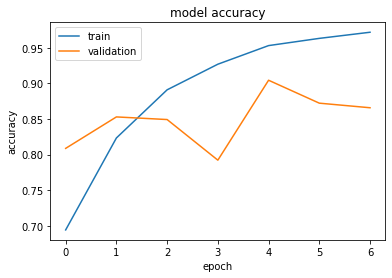

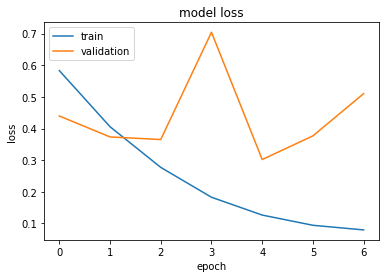

In [ ]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

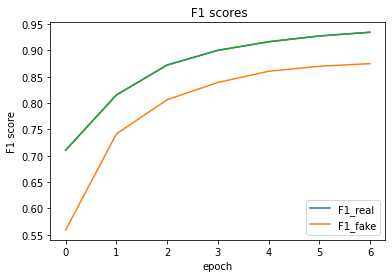

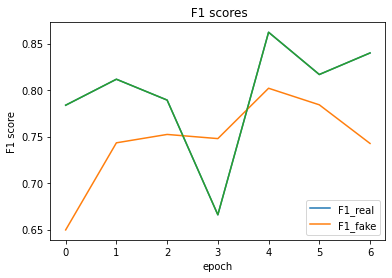

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['f1'])
plt.plot(history.history['F1_real'])
plt.plot(history.history['F1_fake'])

plt.title(' F1 scores')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend([ 'F1_real','F1_fake'], loc='lower right')
plt.show()
# "Loss"

plt.plot(history.history['val_f1'])
plt.plot(history.history['val_F1_real'])
plt.plot(history.history['val_F1_fake'])
plt.title(' F1 scores')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend([ 'F1_real','F1_fake'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


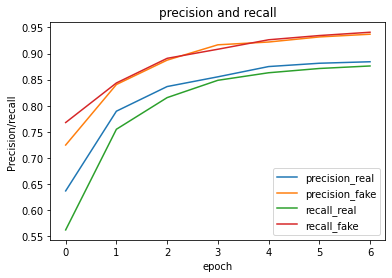

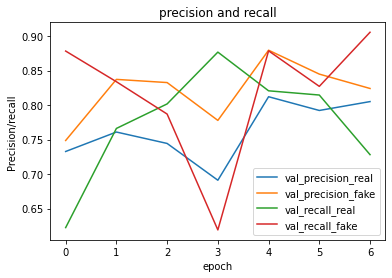

In [ ]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt


plt.plot(history.history['precision_real'])
plt.plot(history.history['precision_fake'])
plt.plot(history.history['recall_real'])
plt.plot(history.history['recall_fake'])

plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['precision_real','precision_fake','recall_real','recall_fake'], loc='lower right')
plt.show()
# "Loss"


plt.plot(history.history['val_precision_real'])
plt.plot(history.history['val_precision_fake'])
plt.plot(history.history['val_recall_real'])
plt.plot(history.history['val_recall_fake'])

plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['val_precision_real','val_precision_fake','val_recall_real','val_recall_fake'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


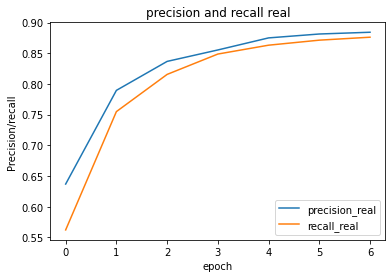

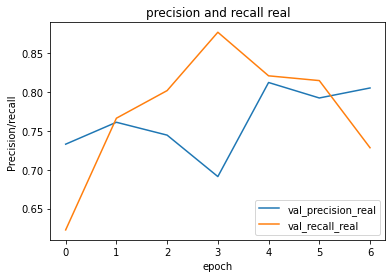

In [ ]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt


plt.plot(history.history['precision_real'])

plt.plot(history.history['recall_real'])


plt.title('precision and recall real')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['precision_real','recall_real'], loc='lower right')
plt.show()
# "Loss"


plt.plot(history.history['val_precision_real'])

plt.plot(history.history['val_recall_real'])


plt.title('precision and recall real')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['val_precision_real','val_recall_real'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


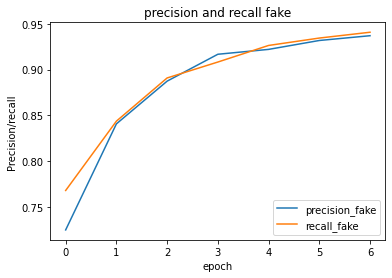

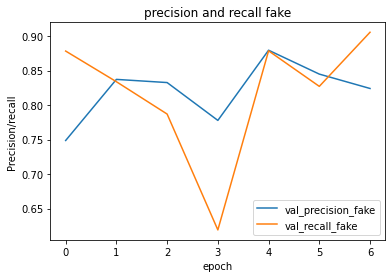

In [ ]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt



plt.plot(history.history['precision_fake'])

plt.plot(history.history['recall_fake'])

plt.title('precision and recall fake')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['precision_fake','recall_fake'], loc='lower right')
plt.show()
# "Loss"



plt.plot(history.history['val_precision_fake'])

plt.plot(history.history['val_recall_fake'])

plt.title('precision and recall fake')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['val_precision_fake','val_recall_fake'], loc='lower right')
plt.show()

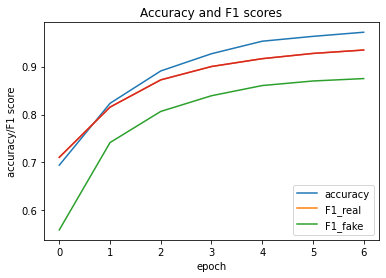

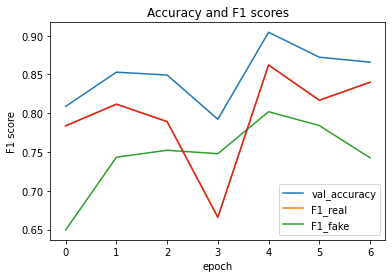

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['f1'])
plt.plot(history.history['F1_real'])
plt.plot(history.history['F1_fake'])

plt.title('Accuracy and F1 scores')
plt.ylabel('accuracy/F1 score')
plt.xlabel('epoch')
plt.legend(['accuracy', 'F1_real','F1_fake'], loc='lower right')
plt.show()
# "Loss"
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_f1'])
plt.plot(history.history['val_F1_real'])
plt.plot(history.history['val_F1_fake'])
plt.title('Accuracy and F1 scores')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['val_accuracy', 'F1_real','F1_fake'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


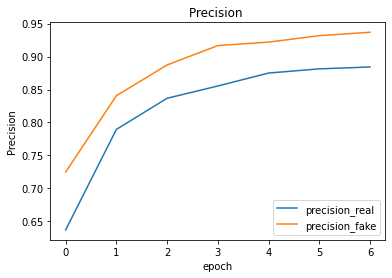

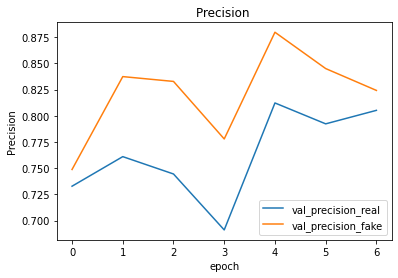

In [ ]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt


plt.plot(history.history['precision_real'])
plt.plot(history.history['precision_fake'])


plt.title('Precision ')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['precision_real','precision_fake'], loc='lower right')
plt.show()
# "Loss"


plt.plot(history.history['val_precision_real'])
plt.plot(history.history['val_precision_fake'])


plt.title('Precision ')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['val_precision_real','val_precision_fake'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


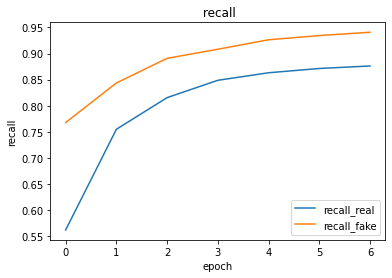

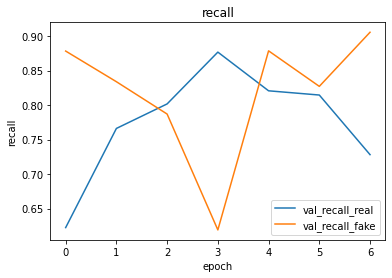

In [ ]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt



plt.plot(history.history['recall_real'])
plt.plot(history.history['recall_fake'])

plt.title(' recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['recall_real','recall_fake'], loc='lower right')
plt.show()
# "Loss"



plt.plot(history.history['val_recall_real'])
plt.plot(history.history['val_recall_fake'])

plt.title('recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['val_recall_real','val_recall_fake'], loc='lower right')
plt.show()

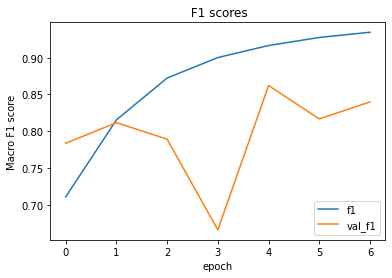

In [ ]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title(' F1 scores')
plt.ylabel('Macro F1 score')
plt.xlabel('epoch')
plt.legend(['f1','val_f1'], loc='lower right')
plt.show()

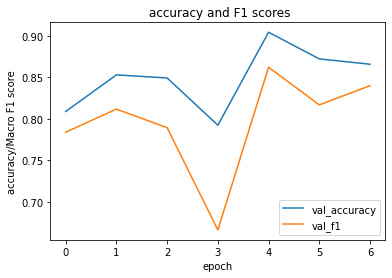

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_f1'])

plt.title(' accuracy and F1 scores')
plt.ylabel('accuracy/Macro F1 score')
plt.xlabel('epoch')
plt.legend(['val_accuracy','val_f1'], loc='lower right')
plt.show()